# JUPYTER CON CODICE PER IL ROUND (1v1)

Strategies:
* **Nice guy**: always cooperate (the function's output is always $u_C$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **Tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move
* **Random guy**: randomly defect or cooperate
* **Resentful guy**: cooperate until the opponent defects once, then always defect
* **Trusting guy**: initially is like random guy (coop/defect at k=50%), then updates k according to match history (% of coop over the total)
* **Balancing guy**: cooperates only for an even cooperation history, otherwise defect
* **Mid Resentful guy**: usually cooperates, unless the opponent has defected on any of the previous 3 moves
* **Reverse Tit-for-tat**: it does the reverse of Tft. It defects on the first move, then plays the reverse of the opponent’s last move.
* **Scamming Guy**: start by defecting, then cooperating two times; for the following turns chose the optimal condition based on how the adversary did

In [28]:
# IMPORT BLOCK:____________________________________________

import numpy as np
from numpy import random as npr
import pandas as pd
from matplotlib import pyplot as plt
import copy
import itertools
# import itertools as it

# npr.seed(69420)

In [29]:
# INITIAL DATA:_____________________________________________
cooperate = np.array( [ 1, 0 ] )
defect = np.array( [ 0, 1 ] )

# default Payoff matrix
default_R = 2
default_S = 0
default_T = 3
default_P = 1
Payoff = np.array( [ [ default_R , default_S ], [ default_T, default_P ] ] )

In [30]:
# NEW STRATEGIES:________________________________________________

# defining all strategies
# # template function
# parameter_list = [ k, ]
# def strategy( round_number = 0, match_history = [[]], player_index = 0 ) : 
#     # move either cooperate or defect
#     move
#     return move 

# nice guy function
def nice_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    return move 

# bad guy function
def bad_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = defect
    return move 

# percentage of defect for mainly nice ( and 1-k percentage of cooperate for mainly bad) Global Variable
k = 0.25

# mainly nice guy: randomly defect k% of the times and cooperate 100-k %, k<50
def mainly_nice( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < k ) : move = defect
    else :         move = cooperate
    return         move

# mainly bad guy: randomly defect k% of the times and cooperate 100-k %, k>50
def mainly_bad( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# random guy: randomly defect or cooperate
def random_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < 0.5 ) : move = defect
    else :           move = cooperate
    return           move

# tit_for_tat function:  start by cooperating, then repeat what the opponent has done in the previous move
def tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = cooperate
    else :                     move = match_history[ round_number - 1 ][ 1 - player_index ]
    return                     move

# resentful guy function: cooperate until the opponent defects once, then always defect
def resentful_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    if ( round_number > 0 ) :
        for res in match_history : 
            # if any result matching a defect is found, the move is set to defect
            if np.array_equal( res[ 1 - player_index  ], defect ) : move = defect
            # if a defect is found, he would break    
            break
    return move

# trusting guy (increasing odds of cooperating according to match history):
# initially is like random guy (coop/defect at k=50%), then updates k
def trusting_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # starting trust
    k_t = 0.5
    # environmental trust
    if ( round_number > 0 ) :
        # number of cooperative behaviour met
        coop = 0. 
        # increase the value of cooperation by one each cooperation (element 0) seen from the other player (index 1-player_index)
        for res in match_history : coop += res[ 1 - player_index  ][ 0 ]
        # normalizing result over the match history
        k_t = coop / len( match_history )
    u = npr.random( )
    if ( u > k_t ) : move = defect
    else :         move = cooperate
    return         move

# balancing guy (cooperates only for an even cooperation history)
def balancing_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    move = defect
    if ( round_number > 0 ) :
        # total cooperation seen
        coop = 0
        # increase the value of cooperation by one each cooperation (element 0) seen from each side during the match
        for res in match_history : coop += ( res[ 0 ][ 1 ] + res[ 1 ][ 1 ])
        if ( ( coop % 2 ) == 0 ) : move = cooperate
    return                         move

# Mid resentful: cooperates on the first move, and defects if the opponent has defected on any of the previous 3 moves, else cooperates
def mid_resentful( round_number = 0, match_history = [[]], player_index = 0):
    move = cooperate
    # selecting the oldest round to check, 3 before the current one if possible, the starting round otherwise
    start = max(0, round_number - 3)
    for round_i in range( start, round_number ):
        # checking if one of the previous move of the opponent (1-player_index) mach a defect
        if np.array_equal( match_history[round_i][1 - player_index], defect ):   
            move = defect
            # if a result is found, the cycle can break
            break
    return move

# reverse tit_for_tat function: start by defecting, then does the opposite of what the opponent has done in the previous move
def reverse_tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = defect
                               # in this way i obtain the opposite move: [1,1] - [1,0] = [0,1] and [1,1] - [0,1] = [1,0]
    else :                     move = [1,1] - match_history[ round_number - 1 ][ 1 - player_index ]  
    return                     move

# learning to scam guy: start by defecting, then cooperating two times; for the following turns chose the optimal condition:
# if the opponent never defected, he will defect to scam the opponent
# if the opponent cooperated while he cooperated more than he was scammed, he will cooperate, because he sees some kind of intelligence
# otherwise he'll defect to avoid beeing scammed
def scamming_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # default move is defect
    move =  defect
    # selecting first tree moves
    if ( round_number == 0 )   : 
        # print( f"round {round_number}: I defect" )
        move = defect
    elif ( round_number == 1 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    elif ( round_number == 2 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    else :
        # counting number of matching cooperation issues and defected from 0
        matching_coop = 0
        scammed = 0
        # deciding how much history to check
        first_r = npr.randint( 3, ( round_number + 1 ), dtype = int )
        # print( first_r )
        # searching over match history
        for i in range( round_number ) :
            # checking if the result cooperate, cooperate occurs
            if( np.array_equal( match_history[i][0], cooperate ) and np.array_equal( match_history[i][1], cooperate ) ) :
                matching_coop += 1
            # checking if the result cooperate, defect occurs in favour of the opposite side
            elif( np.array_equal( match_history[i][1 - player_index], defect ) and np.array_equal( match_history[i][player_index], cooperate ) ) :
                scammed += 1
        # checking if the opponent has always cooperated or if he has defected even once
        if( np.all( np.array_equiv( np.array( [ match_history[i][ 1 - player_index ] for i in range( ( round_number - first_r ), round_number ) ] ) , cooperate ) ) ) :
            # print( f"The rival is too good, I defect" )
            move = defect
        elif( matching_coop >= scammed ) : 
            # print( f"The rival is smart, I cooperate" )
            move = cooperate
    return move

# dictionary of all strategies
strategies = {
    'NiceGuy' : nice_guy,
    'BadGuy' : bad_guy,
    'MainlyNice' : mainly_nice,
    'MainlyBad' : mainly_bad,
    'TitForTat' : tit_for_tat,
    'RandomGuy' : random_guy,
    'ResentfulGuy' : resentful_guy,
    'TrustingGuy' : trusting_guy,
    'Thanos' : balancing_guy,
    'MidResentful': mid_resentful,
    'ReverseTft': reverse_tit_for_tat,
    'ScammingGuy' : scamming_guy,
}

In [31]:
# NEW MATCH DEFINING FUNCTIONS:________________________________________________

# function to play one round 1 vs 1 for two different* strategies players
def round( key_1, key_2, round_number, match_history, M = Payoff ) :
    # computing minimum and maximum reward for normalization
    # s = np.dot( defect, M.dot( cooperate ) )
    # t = np.dot( cooperate, M.dot( defect ) )
    # getting strategies from dictionary
    S_1 = strategies[ key_1 ]
    S_2 = strategies[ key_2 ]
    # computing next move for each player
    u_1 = S_1( round_number, match_history, 0 )
    u_2 = S_2( round_number, match_history, 1 )
    # computing rewards for each player
    r_1 = np.dot( u_1, M.dot(u_2))
    r_2 = np.dot( u_2, M.dot(u_1))
    # normalizing results
    # r_1 = float( r_1 - s ) / float( t - s )
    # r_2 = float( r_2 - s ) / float( t - s )
    # updating match history
    match_history.append( [ u_1, u_2 ] )
    # returning results
    return r_1, r_2

# function to play a match of N rounds 1 vs 1 for two different* strategies player
def match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
    # match history strarting empty
    history = [ ]
    # starting total rewards
    R_1 = 0
    R_2 = 0
    # list of partial sums
    Rewards = []
    for round_i in range( 0, N_rounds ) :
        r_1, r_2 = round( key_1, key_2, round_i, history, M )
        R_1 += r_1
        R_2 += r_2
        Rewards.append( [ R_1, R_2 ] )
        # normalizing results to round played up this moment
        # Rewards.append( [ float(R_1)/round_i, float(R_2)/round_i ] )
    # returns the history list of partial sums of rounds rewards
    return Rewards


In [32]:
# TEST:
print( round('NiceGuy', 'TitForTat', 0, [[]]) )
print( match('BadGuy', 'MainlyBad', 14) )

(2, 2)
[[1, 1], [2, 2], [5, 2], [6, 3], [9, 3], [12, 3], [13, 4], [14, 5], [17, 5], [20, 5], [23, 5], [24, 6], [25, 7], [28, 7]]


## BENEDETTO code

In [33]:
import numpy as np
from numpy import random as npr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors

#### LET'S TRY DIFFERENT COMBINATIONS OF REWARDS

In [34]:
new_R = 2
new_S = 0
new_T = 3
new_P = 1

# check condition on values:
if (new_T > new_R) and (new_R > new_P) and (new_P > new_S) and (2*new_R > new_T + new_S):
    print("payoffs ok with conditions, matrix created")
    Payoff = np.array( [ [ new_R , new_S ], [ new_T, new_P ] ] )
else: print("problema with payoffs, check conditions")

payoffs ok with conditions, matrix created


OSSERVAZIONI: aumentando T la disparità tra defecting strategies e cooperating strategies diventa solo che più evidente. (da fare check approfondito)

### 1v1 in 1 round, all combinations
Let's build a table of all possible 1v1 of 1 round, so each strategy plays against all the strategies (itself included) for 1 turn play:

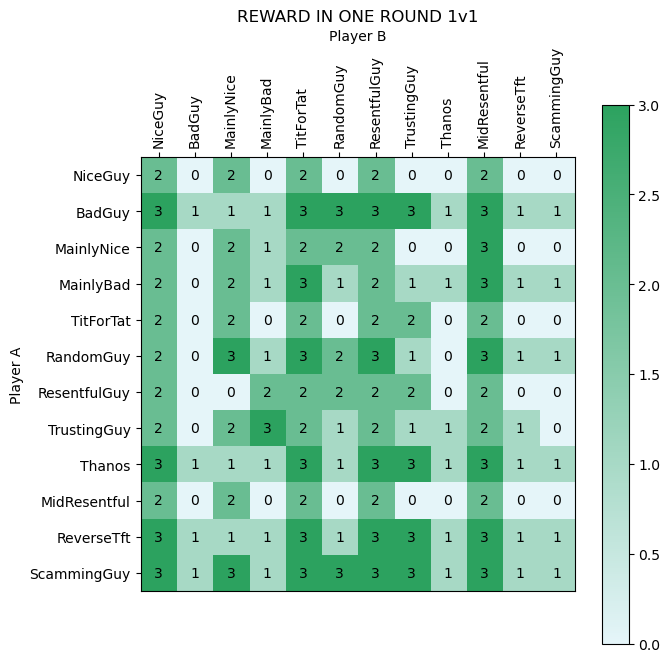

[[2 0]
 [3 1]]


In [35]:
# LET'S CALCULATE THE REWARDS of 1v1 rounds for all strategies:
# let's initialize the matrix of rewards: it will be a list that contains the lists with the rewards for each strategy
# so for example the first row will contain all the rewards of the first strategy vs all strategies (in a 1 turn game each)
table_rewards = []
# cycle over all strategies:
for i, key_1 in enumerate(strategies):
    table_rewards.append([])             # I add a row for each  strategy
    for j, key_2 in enumerate(strategies):
        a, b = round(key_1, key_2, round_number=0, match_history=[[]], M = Payoff )
        table_rewards[i].append(a)
# debug:
# print(table_rewards)


# PLOT of the table:
fig, ax = plt.subplots(1, 1 ,figsize=(7,7))
# Creiamo una colormap che va da verde scuro a verde chiaro (usando i codici XKCD dei colori):
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green", [ "#e5f5f9", "#2ca25f"])
# creiamo il plot con plt.imshow():
graph = ax.imshow(table_rewards, cmap=custom_cmap)
plt.colorbar(graph)
# Etichette per gli assi con nomi delle strategie:
strategy_names = list(strategies.keys())
plt.xticks( ticks=np.arange(len(strategy_names)), labels=strategy_names, rotation=90 )  # rotation for vertical labels
plt.yticks( ticks=np.arange(len(strategy_names)), labels=strategy_names)
ax.xaxis.set_label_position('top')     # sposto in alto l'asse x
ax.xaxis.tick_top()                    # sposto in alto i labels dell'asse x
# Scriviamo i valori numerici nelle celle:
for i in range(len(strategy_names)):
    for j in range(len(strategy_names)):
        # j,i are inverted because in matplotlib, like in cartesian coordinates, x refers to ascisse so columns, y to ordinate so rows
        # 'ha and 'va' are horizontal and vertical alignment
        plt.text(j, i, str(table_rewards[i][j]), ha='center', va='center', color='black')
plt.title("REWARD IN ONE ROUND 1v1")
plt.xlabel("Player B")
plt.ylabel("Player A")
plt.show()

print(Payoff)

OSSERVAZIONE: As we can see, excluding noise due to strategies relying on random input, the evident winning strategy for 1 turn game is to **defect** (see reward rows for bad guy, thanos, reverse-tft...) instead strategies like nice guy are losing strategies. This is excpeted because in a one turn game logically we have two possibilities: by cooperating we could get 2 or 0 as rewards, but by defecting 3 or 1.

### 1v1 matches, all combinations
Let's build a table of all possible 1v1 of 1 matches:

(memo: a match is a sequence of 1v1 rounds)

In [36]:
N = 20        # number of rounds

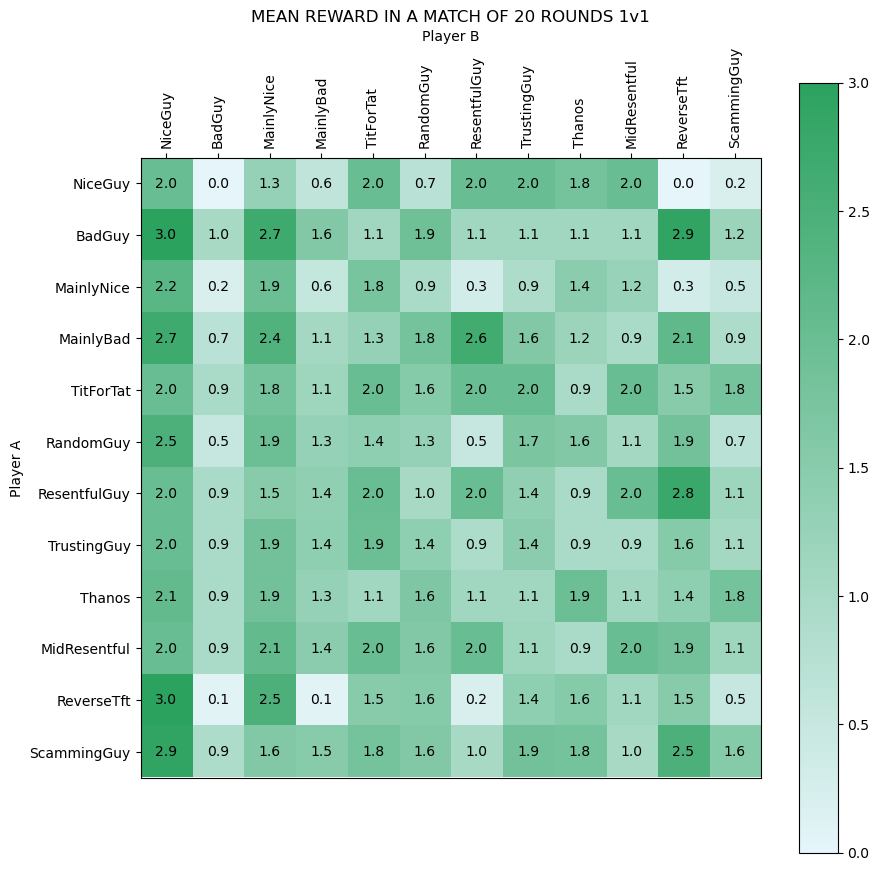

In [37]:
table_rewards = []               # let's initialize the matrix of rewards of 1v1 rounds for all strategies: dim=(num_strateg)x(num_strateg)
table_partial_rewards = []       # matrix of partial rewards, for the graphs. dim=(num_strateg)x(num_strateg)xNx2
 
# cycle over all strategies:
for i, key_1 in enumerate(strategies):
    table_rewards.append([])             # I add a row for each  strategy
    table_partial_rewards.append([])
    for j, key_2 in enumerate(strategies):
        rew = match(key_1, key_2, N, M = Payoff )   # memo: it returns a chronological list of partial rewards
        table_rewards[i].append(rew[-1][0]/N)       # "/N" for normalization  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        table_partial_rewards[i].append(rew)
# debug:
# print(table_rewards)


# PLOT of matches rewards (as before):
fig, ax = plt.subplots(1, 1 ,figsize=(10,10))
graph = ax.imshow(table_rewards, cmap=custom_cmap)
plt.colorbar(graph)
plt.xticks( ticks=np.arange(len(strategy_names)), labels=strategy_names, rotation=90 ) 
plt.yticks( ticks=np.arange(len(strategy_names)), labels=strategy_names)
ax.xaxis.set_label_position('top')  
ax.xaxis.tick_top()  
# Inseriamo i valori nelle celle:
for i in range(len(strategy_names)):
    for j in range(len(strategy_names)):
        plt.text(j, i, f"{table_rewards[i][j]:.1f}", ha='center', va='center', color='black')
plt.title(f"MEAN REWARD IN A MATCH OF {N} ROUNDS 1v1")
plt.xlabel("Player B")
plt.ylabel("Player A")
plt.show()

OSSERVAZIONE: Also in matches the conclusion is the same: defecting strategies (like bad guy, thanos, reverse-tft...) are winning strategies, instead strategies like nice guy are losing strategies. This is also expected because for now the goal is to win the match (not the total amount of rewards) so the case of (3,1) rewards given to defecting are always (=at every turn) more appealing than cooperating (= possible rewards (0,2)).

MORAL: in a world with only 1 competitor, the best choice is to defect (homo homini lupus hehehe).

#### ANDAMENTO DEI MATCH
We want to show some meaningful graphs showing the trend of rewards of some matches between strategies

memo: *table_partial_rewards* is a matrix of partial rewards, for the graphs. It has dim=(num_strateg)x(num_strateg)xNx2, i.e. it's a grid of (num_strateg)x(num_strateg), and in every cell in position (i,j) I saved the list Nx2 of chronological partial rewards for the battle of strategies i vs j

Text(0.1, 0.5, 'PLAYER A (blue)')

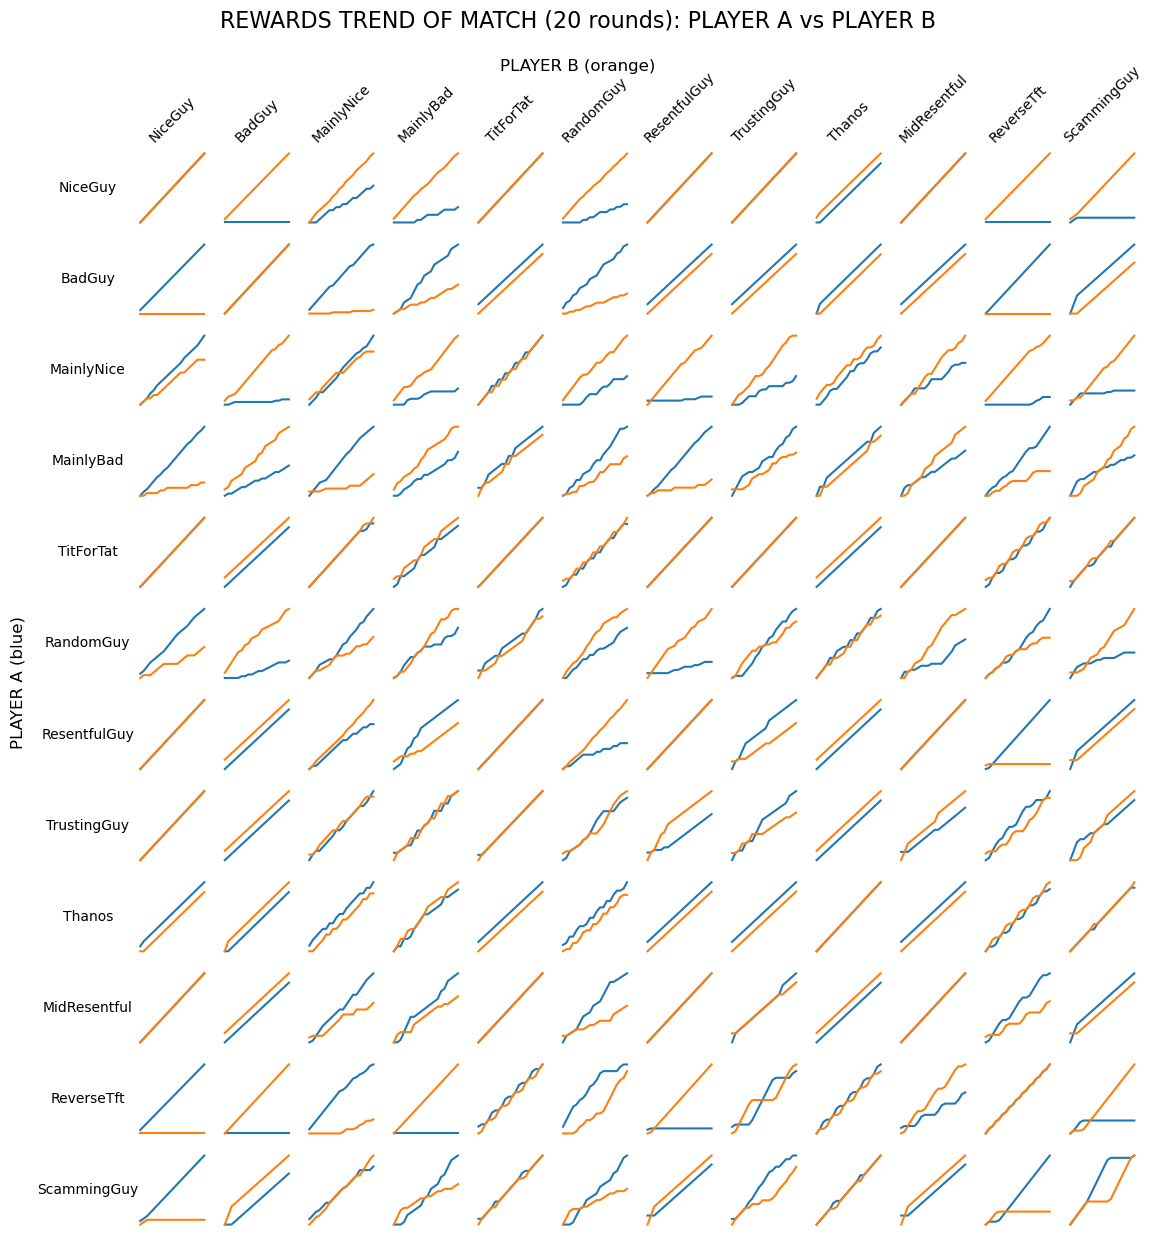

In [38]:
# PLOT of partial rewards to see the evolution of matches:

strategy_names = list(strategies.keys())                              # list with the strategy names
num_strat = len(strategies)                                           # number of strategies

fig, axs = plt.subplots(num_strat, num_strat+1 ,figsize=(14,14))      # one more column for writing strategy names
x_axis = np.arange(N)          # array for x axis plots

# let's plot graphs:
for i in range(num_strat):
    for j in range(1, num_strat+1):
        rew_i, rew_j = zip( *table_partial_rewards[i][j-1] )           # extrapolate array of rewards for the two strategies
        axs[i][j].plot(x_axis, rew_i)
        axs[i][j].plot(x_axis, rew_j)
        axs[i][j].axis("off")                                          # remove axes and values for clarity

# let's write strategy names on x axis:
for j in range(num_strat):
    axs[0][j+1].set_title(f"{strategy_names[j]}", rotation=45, fontsize=10)         # rotation for clarity

# let's write strategy names in blank first column of graphs (so on y axis)
for i in range(num_strat):
    axs[i][0].axis("off") 
    axs[i][0].text(0.5,0.5,f"{strategy_names[i]}", ha='center', va='center', color='black')

# overall title and axis names
fig.suptitle(f"REWARDS TREND OF MATCH ({N} rounds): PLAYER A vs PLAYER B", fontsize=16)
fig.text(0.5, 0.94, 'PLAYER B (orange)', ha='center', va='center', fontsize=12)  # Asse X
fig.text(0.1, 0.5, 'PLAYER A (blue)', ha='center', va='center', rotation='vertical', fontsize=12)  # Asse Y

OSSERVAZIONI:
Per numeri bassi di rounds (N<30) le differenze nelle prestazioni delle strategie sono ben visibili in molteplici sfumature, mostrando cambi di rotta e 'sorpassi'. Utilizzando un numero alto invece (N>30) i grafici non mostrano grandi peculiarità, dividendosi perlopiù in due classi: accoppiate più o meno alla pari (ovvero le strategie che si allineano a quella affrontata) e altre stravincenti su altre straperdenti (es bad vs nice).  
Ciò era prevedibile dal fatto che molte delle strategie utilizzate, escludendo quelle 'fisse' (nice, bad, random..) presentano decisioni particolari proprio nei primi round di gioco, per poi assestarsi quasi sempre su una strategia fissa.  
(provare a runnare con diversi valori di N per verificare)


Let's zoom now on the matches of a defecting strategy like BadGuy:

Text(0.5, 0.98, 'REWARDS TREND OF MATCH (20 rounds): BAD GUY vs PLAYER B')

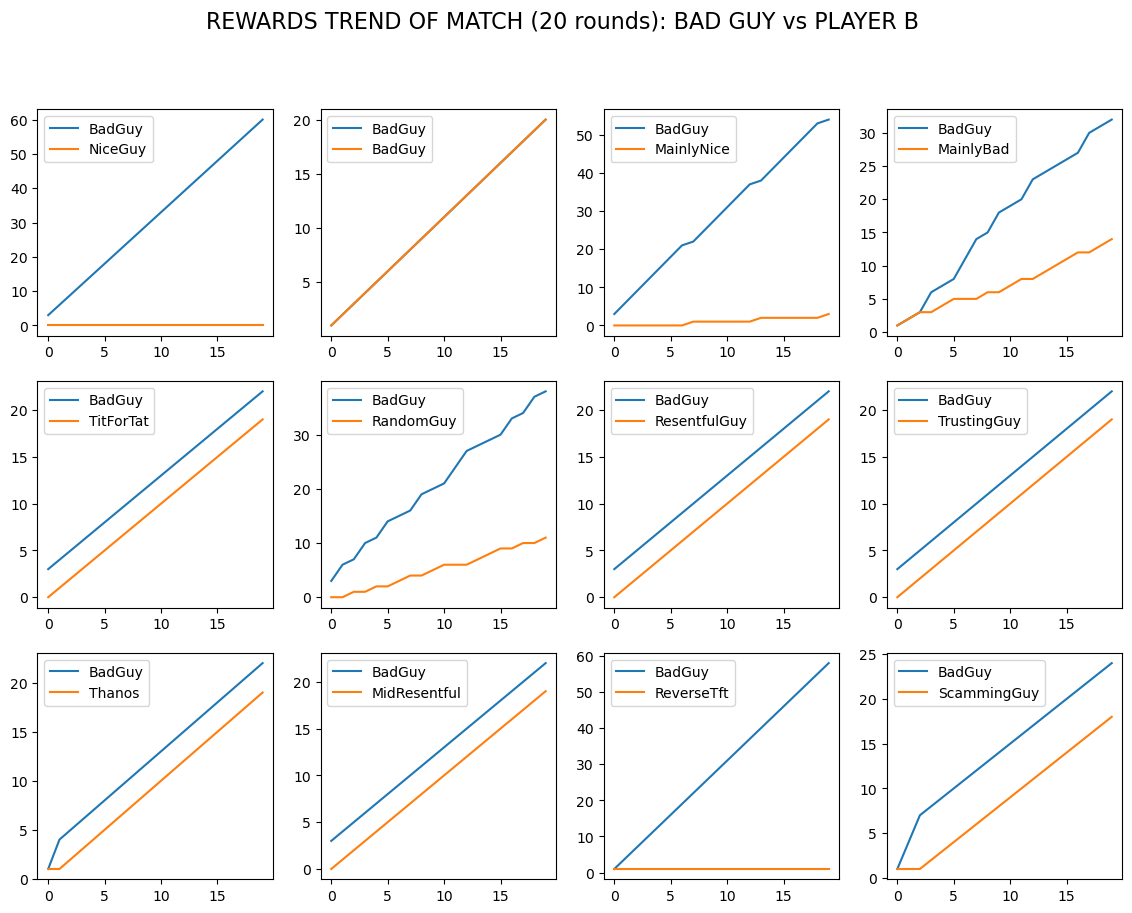

In [39]:
# PLOT of bad_guy matches

fig, axs = plt.subplots(3, 4 ,figsize=(14,10))      
x_axis = np.arange(N)                                                 # array for x axis plots

# let's plot graphs:
k = 0
for i in range(3):
    for j in range(4):
        rew_i, rew_j = zip( *table_partial_rewards[1][k] )           # extrapolate array of rewards for the two strategies
        axs[i][j].plot(x_axis, rew_i, label="BadGuy")
        axs[i][j].plot(x_axis, rew_j, label=f"{strategy_names[k]}")
        axs[i][j].legend()
        k = k +1

# overall title:
fig.suptitle(f"REWARDS TREND OF MATCH ({N} rounds): BAD GUY vs PLAYER B", fontsize=16)

OSSERVAZIONE: as said before, defecting strategies (like bad guy above) are winning strategies. In our example the bad guy is winning every match, except a draw with himself.

## DA IMPLEMENTARE:
* aggiungere delle infografiche su come si è scritto il programma (?)